In [2]:
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [4]:
# import os
# import shutil

# # Path direktori yang ingin dikosongkan
# dir_path = '/content'

# # Fungsi untuk menghapus semua file dan folder kecuali drive di dalam direktori
# def empty_directory_except_drive(directory):
#     for filename in os.listdir(directory):
#         file_path = os.path.join(directory, filename)
#         try:
#             if file_path != '/content/drive':
#                 if os.path.isfile(file_path) or os.path.islink(file_path):
#                     os.unlink(file_path)
#                 elif os.path.isdir(file_path):
#                     shutil.rmtree(file_path)
#         except Exception as e:
#             print(f"Failed to delete {file_path}. Reason: {e}")

# # Memanggil fungsi untuk mengosongkan direktori kecuali drive
# empty_directory_except_drive(dir_path)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import zipfile
import os

# Path to the ZIP file in your Google Drive
zip_file_path = '/content/drive/MyDrive/KidneyDisease/CT-KIDNEY-DATASET-Reduced.zip'

# Directory to extract the contents of the ZIP file
extracted_dir_path = '/content/dataset/'

In [7]:
# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# List the contents of the extracted directory
extracted_files = os.listdir(extracted_dir_path)
print("Extracted Files:", extracted_files)

Extracted Files: ['CT-KIDNEY-DATASET-Reduced', '__MACOSX']


In [8]:
extracted_dir_path = "/content/dataset/CT-KIDNEY-DATASET-Reduced"
dataset = tf.keras.utils.image_dataset_from_directory(
    extracted_dir_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2719 files belonging to 4 classes.


In [9]:
class_names = dataset.class_names
class_names

['Cyst', 'Normal', 'Stone', 'Tumor']

In [10]:
# Hitung jumlah sampel per kelas
class_samples_count = {}
total_samples = 0

for class_name in class_names:
    samples_count = sum(1 for _ in os.listdir(os.path.join(extracted_dir_path, class_name)))
    class_samples_count[class_name] = samples_count
    total_samples += samples_count

# Tampilkan jumlah sampel per kelas
for class_name, count in class_samples_count.items():
    print(f"Class: {class_name}, Number of samples: {count}")

# Tampilkan jumlah total sampel
print(f"Total number of samples: {total_samples}")

Class: Cyst, Number of samples: 608
Class: Normal, Number of samples: 878
Class: Stone, Number of samples: 615
Class: Tumor, Number of samples: 622
Total number of samples: 2723


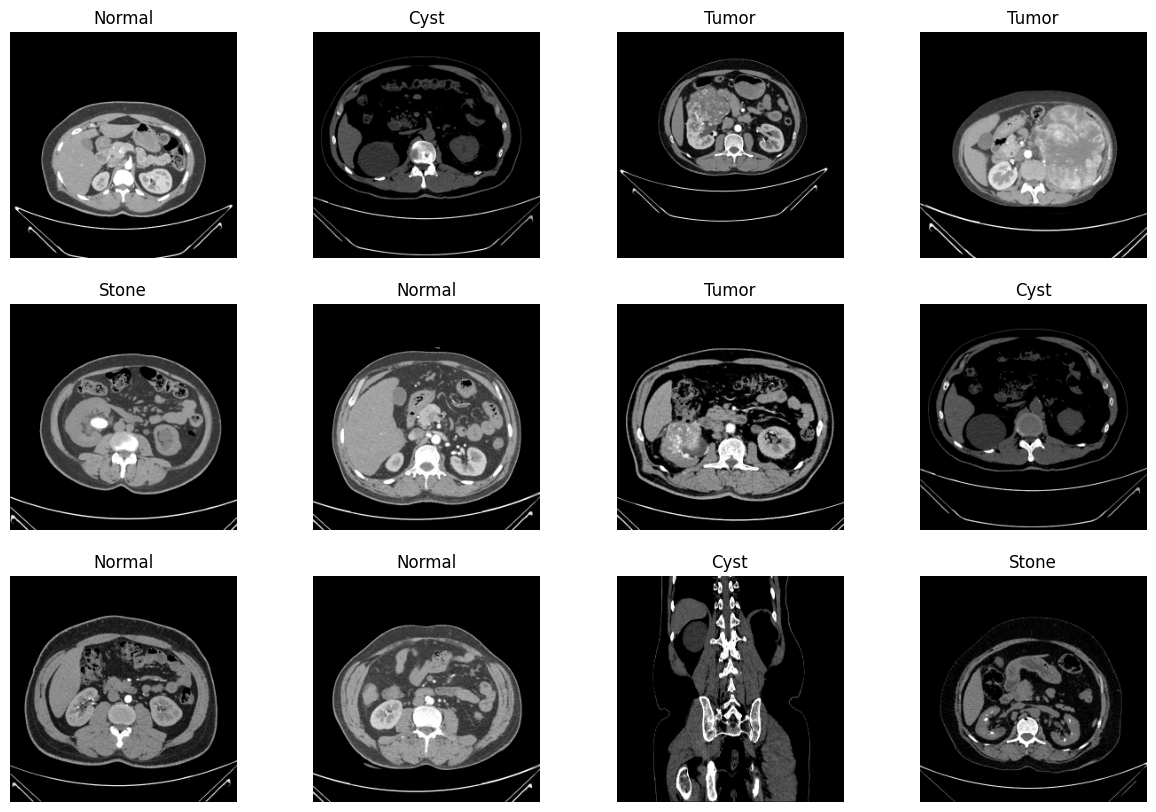

In [11]:
plt.figure(figsize=(15,10))
for image_batch, label_batch in dataset.take (1):
    for i in range(12) :
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [12]:
#80% ==> training
#20% ==> 10% validation, 10% test
len(dataset)

85

In [13]:
train_size = 0.8
len(dataset)*train_size

68.0

In [14]:
#80% ==> training
train_ds = dataset.take(68)
len(train_ds)

68

In [15]:
test_ds = dataset.skip(68)
len(test_ds)

17

In [16]:
val_size = 0.1
len(dataset) * val_size

8.5

In [17]:
#10% ==> validation
val_ds = test_ds.take(9)
len(val_ds)

9

In [18]:
#10% ==> test
test_ds = test_ds.skip(9)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000) :

    ds_size = len(ds)

    if shuffle :
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)  #80%
    val_size = int(val_split * ds_size)  #10%

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [109]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
68/68 [==============================] - 35s 233ms/step - loss: 1.1297 - accuracy: 0.4814 - val_loss: 0.7507 - val_accuracy: 0.7070
Epoch 2/20
68/68 [==============================] - 4s 61ms/step - loss: 0.7928 - accuracy: 0.6589 - val_loss: 0.6568 - val_accuracy: 0.6914
Epoch 3/20
68/68 [==============================] - 4s 62ms/step - loss: 0.6434 - accuracy: 0.7287 - val_loss: 0.5035 - val_accuracy: 0.7852
Epoch 4/20
68/68 [==============================] - 4s 64ms/step - loss: 0.5118 - accuracy: 0.7857 - val_loss: 0.3833 - val_accuracy: 0.8359
Epoch 5/20
68/68 [==============================] - 4s 66ms/step - loss: 0.3495 - accuracy: 0.8598 - val_loss: 0.5255 - val_accuracy: 0.7891
Epoch 6/20
68/68 [==============================] - 4s 61ms/step - loss: 0.3262 - accuracy: 0.8832 - val_loss: 0.2300 - val_accuracy: 0.8984
Epoch 7/20
68/68 [==============================] - 4s 63ms/step - loss: 0.2348 - accuracy: 0.9071 - val_loss: 0.1755 - val_accuracy: 0.9375
Epoch 8/20


In [24]:
scores = model.evaluate(test_ds)
scores

9/9 [==============================] - 0s 39ms/step - loss: 0.0418 - accuracy: 0.9896


[0.041764769703149796, 0.9895833134651184]

In [25]:
history.params
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

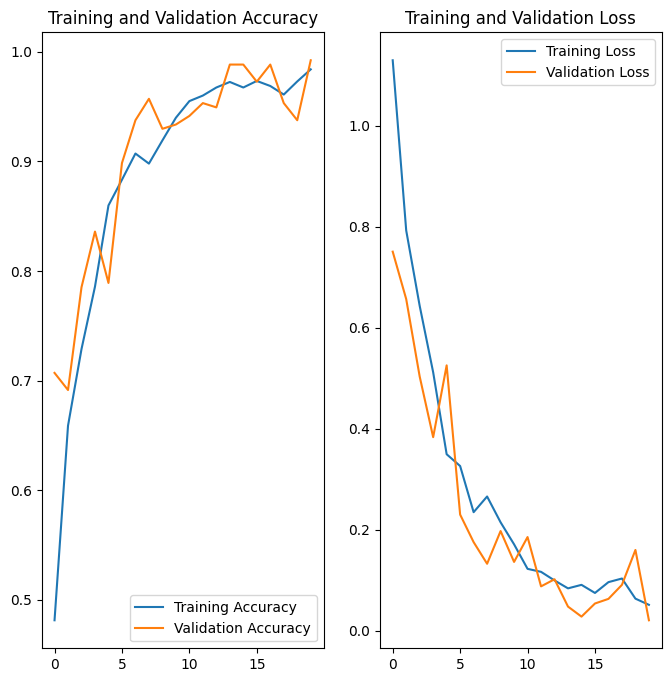

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [112]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Ekstraksi vektor fitur dari model CNN
features_train = model.predict(train_ds)  # Ekstraksi fitur untuk data pelatihan
features_val = model.predict(val_ds)  # Ekstraksi fitur untuk data validasi
features_test = model.predict(test_ds)  # Ekstraksi fitur untuk data uji

# Get the number of samples in your dataset
num_train_samples = features_train.shape[0]
num_val_samples = features_val.shape[0]
num_test_samples = features_test.shape[0]

# Calculate the size of the extracted features
feature_size = features_train.shape[1]

# Reshape the features arrays to 1D based on the number of samples
train_features_1d = features_train.reshape(num_train_samples, feature_size)
val_features_1d = features_val.reshape(num_val_samples, feature_size)
test_features_1d = features_test.reshape(num_test_samples, feature_size)

9/9 [==============================] - 0s 14ms/step


In [136]:
# Fungsi untuk menghitung output ELM
def elm_predict(X, weights, biases):
    return np.dot(X, weights) + biases

# Fungsi aktivasi sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Fungsi untuk melatih ELM
def train_elm(X_train, y_train, num_hidden_neurons):
    input_size = X_train.shape[1]

    # Inisialisasi bobot dan bias secara acak
    input_weights = np.random.rand(input_size, num_hidden_neurons)
    biases = np.random.rand(num_hidden_neurons)

    # Hitung output lapisan tersembunyi menggunakan fungsi aktivasi (misalnya, sigmoid)
    hidden_output = sigmoid(np.dot(X_train, input_weights) + biases)

    # Hitung bobot keluaran ELM menggunakan invers pseudo
    output_weights = np.dot(np.linalg.pinv(hidden_output), y_train)

    return input_weights, biases, output_weights

In [129]:
# Extract labels from train_ds
train_labels = []
for _, labels_batch in train_ds:
    train_labels.extend(labels_batch.numpy())

# Convert train_labels to numpy array
train_labels = np.array(train_labels)

In [137]:
num_hidden_neurons = 4
input_weights, biases, output_weights = train_elm(features_train, train_labels, num_hidden_neurons)

# Ekstraksi fitur untuk data uji menggunakan model CNN
features_test_cnn = model.predict(test_ds)

# Reshape fitur ke dalam format 1D
num_test_samples_cnn = features_test_cnn.shape[0]
test_features_1d_cnn = features_test_cnn.reshape(num_test_samples_cnn, feature_size)

# Hitung output ELM untuk data uji dari model CNN
hidden_output_test_cnn = sigmoid(np.dot(test_features_1d_cnn, input_weights) + biases)

# Hitung output ELM untuk data uji dari model CNN
predicted_labels_test_cnn = elm_predict(hidden_output_test_cnn, input_weights, biases)


9/9 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 171ms/step


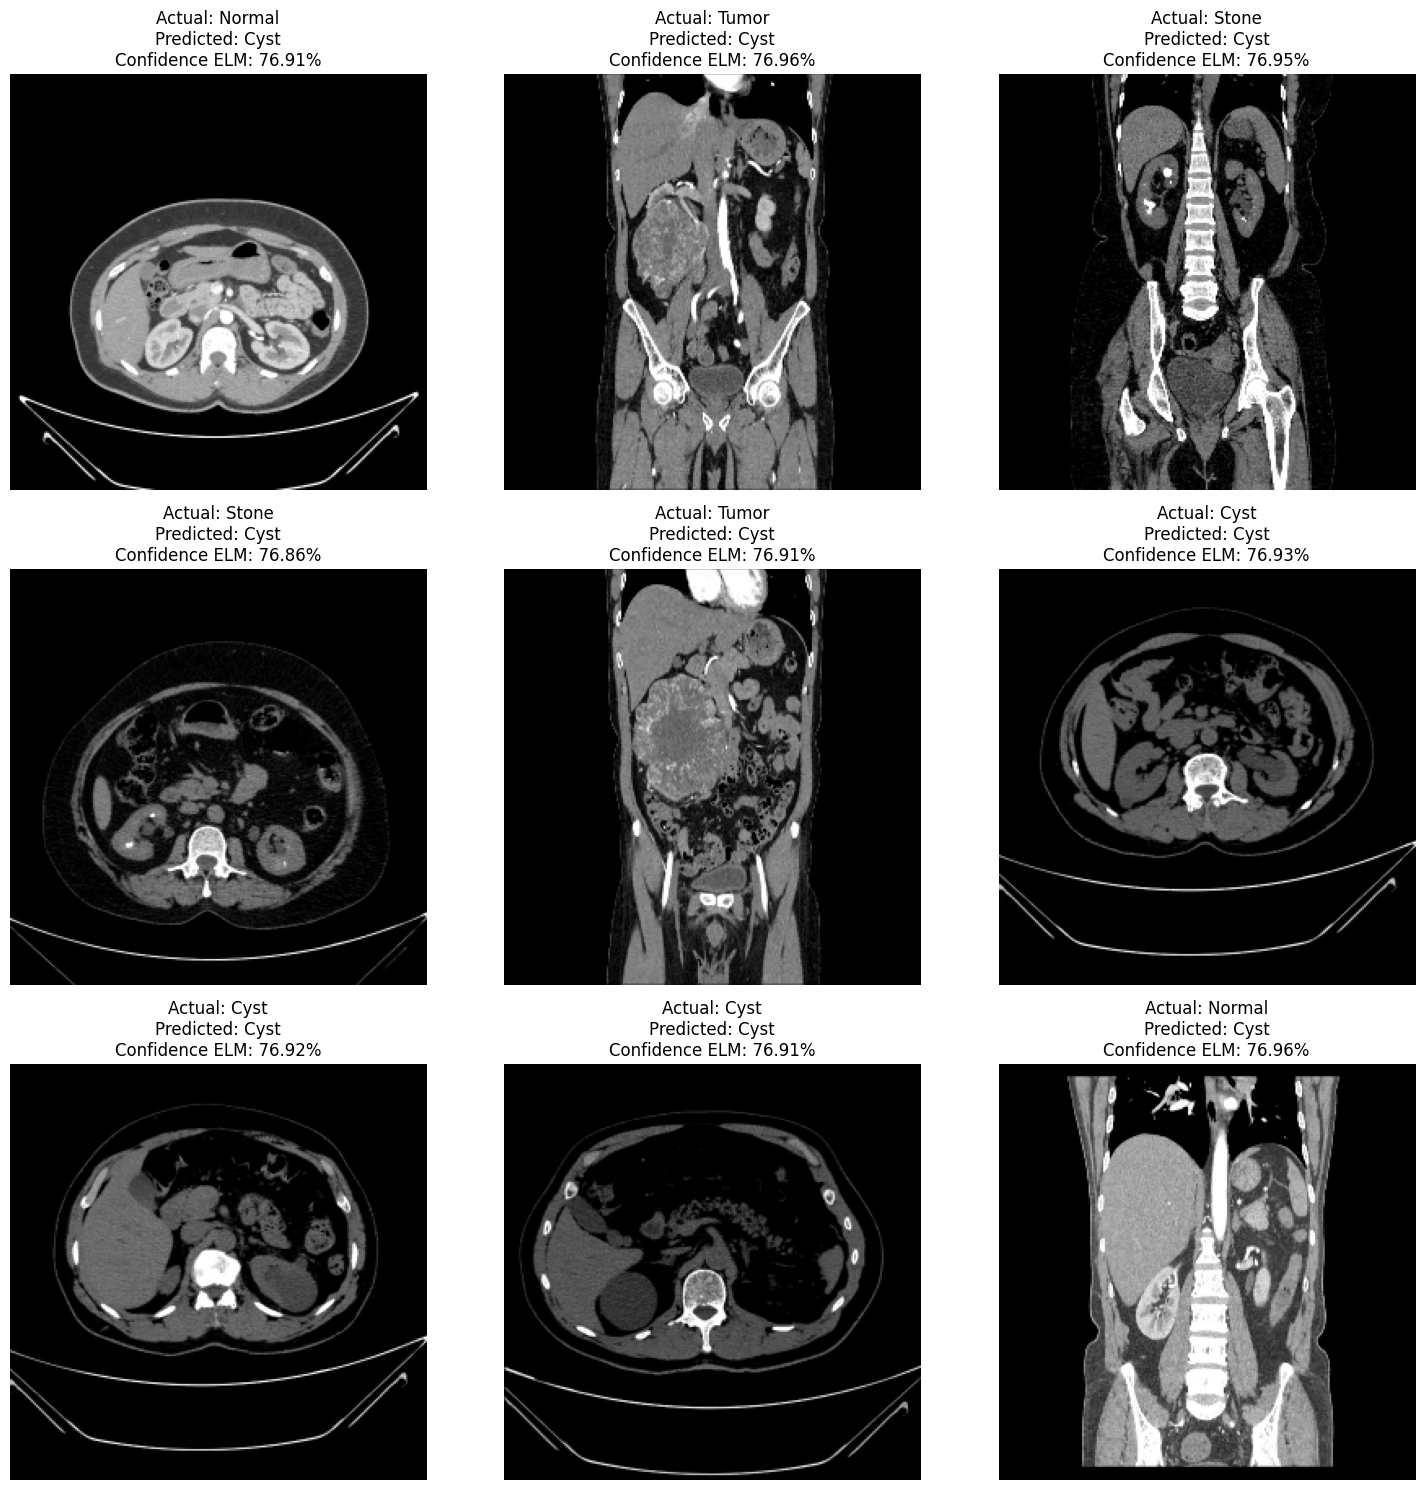

In [138]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    features_test_cnn = model.predict(images)  # Extract features using CNN

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Predict using ELM with CNN features
        features_test_cnn_1d = features_test_cnn[i].reshape(1, -1)
        hidden_output_test_cnn = sigmoid(np.dot(features_test_cnn_1d, input_weights) + biases)
        predicted_label = np.argmax(elm_predict(hidden_output_test_cnn, input_weights, biases))

        predicted_class = class_names[predicted_label]
        actual_class = class_names[labels[i]]

        # Confidence calculation
        confidence = np.max(hidden_output_test_cnn) * 100

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence ELM: {confidence:.2f}%")
        plt.axis("off")

plt.tight_layout()
plt.show()

# **IMPORT**

In [ ]:
# import os

# # Specify the path to the directory
# directory_path = "/content/drive/MyDrive/KidneyDisease/model"

# # Create the directory if it doesn't exist
# os.makedirs(directory_path, exist_ok=True)

# # Get the model version
# model_version = max([int(i) for i in os.listdir(directory_path) + [0]]) + 1

# # Save the model
# model.save(f"{directory_path}/{model_version}")
